<a href="https://colab.research.google.com/github/meeks627/BeyondAI-KANs-vs-MLPs-Colab-Code/blob/main/MY_BAI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imodelsx

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imodelsx import KANClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
# from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings(action='ignore')

##Kolmogrov Arnold Network (KAN)

In [ ]:
# initializinng a KANHClassifier using CPU acceleration(cpu device)
# Default parameter for  KANClassifier are as follows:
# regularize_activation = 1.0
# regularize_entropy = 1.0
# regularize_ridge = 0.0
# grid_size = 5
# spline_order = 3
# scale_noise = 0.1
# scale_base = 1.0
# scale_spline = 1.0
# base_activation = torch.nn.SILU
# grid_eps = 0.02
# grid_range = [-1,1]
kan = KANClassifier(device='cpu',)

##Multi-Layer Perceptron

In [ ]:
mlp =  MLPClassifier(hidden_layer_sizes=(64, 32),
                     activation='tanh',
                     solver='sgd',
                     learning_rate_init=0.001,
                     alpha=0.0001,
                     max_iter=1000,
                     random_state=42,
                     verbose= False)

## Load Data

In [ ]:
url_wine = 'https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv'
df = pd.read_csv(url_wine)
x = df.drop('Wine',axis=1).values
y = df['Wine'].values

##Prepare Data

In [ ]:
x_train,y_train,x_test,y_test = train_test_split(x,y,test_size=0.4,random_state=42)
x_train = torch.tensor(x, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)
x_test = torch.tensor(x, dtype=torch.float32)
y_test = torch.tensor(y, dtype=torch.float32)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Computing the Functions


In [ ]:
def mlp_run(model):
  print("MLP RESULTS")
  mlp.fit(x_train,y_train)
  y_pred_mlp = mlp.predict(x_test)
  print(f'Accuracy Score: {accuracy_score(y_test,y_pred_mlp)}')
  print(f'Confusion Matrix: \n{confusion_matrix(y_test,y_pred_mlp)}')
  print(f'Classification Report: \n{classification_report(y_test,y_pred_mlp)}')
  criterion1 = nn.MSELoss()
  loss_mlp  = criterion1(torch.tensor(y_pred_mlp),torch.tensor(y_test))
  return y_pred_mlp,loss_mlp

def kan_run(model):
    print("KAN RESULTS")
    for i in range(20):
      model.fit(x_train,y_train)
      y_pred_kan = model.predict(x_test)
      print(f'Accuracy Score: {accuracy_score(y_test,y_pred_kan)}')
      print(f'Confusion Matrix: \n{confusion_matrix(y_test,y_pred_kan)}')
      print(f'Classification Report: \n{classification_report(y_test,y_pred_kan)}')
      criterion2 = nn.MSELoss()
      loss_kan = criterion2(torch.tensor(y_pred_kan),torch.tensor(y_test))
      return y_pred_kan,loss_kan


def plot_results(models, losses, accuracies, f1_scores):
   x = range(len(models))
   plt.figure(figsize=(20, 8))
   plt.subplot(131)
   plt.bar(x, losses, color=['red', 'blue'])
   plt.xticks(x, models)
   plt.ylabel('Loss')
   plt.title('Model Loss Comparison')

   plt.subplot(132)
   plt.bar(x, accuracies, color=['red', 'blue'])
   plt.xticks(x, models)
   plt.ylabel('Accuracy')
   plt.title('Model Accuracy Comparison')

   plt.subplot(133)
   plt.bar(x, f1_scores, color=['red', 'blue'])
   plt.xticks(x, models)
   plt.ylabel('F1 Score')
   plt.title('Model F1 Score Comparison')
   plt.tight_layout()
   plt.show()




##Running the Code

In [ ]:
y_pred_mlp,loss_mlp = mlp_run(mlp)
y_pred_kan, loss_kan = kan_run(kan)

print(f' MLP has a loss of {loss_mlp}')
print(f' KAN has a loss of {loss_kan}')

MLP RESULTS
Accuracy Score: 0.9887640449438202
Confusion Matrix: 
[[59  0  0]
 [ 0 70  1]
 [ 0  1 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        59
         2.0       0.99      0.99      0.99        71
         3.0       0.98      0.98      0.98        48

    accuracy                           0.99       178
   macro avg       0.99      0.99      0.99       178
weighted avg       0.99      0.99      0.99       178

KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 58.08it/s]


Accuracy Score: 0.6235955056179775
Confusion Matrix: 
[[44  8  7]
 [ 3 44 24]
 [23  2 23]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.63      0.75      0.68        59
         2.0       0.81      0.62      0.70        71
         3.0       0.43      0.48      0.45        48

    accuracy                           0.62       178
   macro avg       0.62      0.61      0.61       178
weighted avg       0.65      0.62      0.63       178

 MLP has a loss of 0.01123595517128706
 KAN has a loss of 0.882022500038147


## Hyperparameter Tunning

##MLP

In [ ]:
clf = GridSearchCV(mlp, {'hidden_layer_sizes': [(64, 32), (128, 64,32),(26,90),(64,32,6),(128,64,16)],
                        'activation': ['relu', 'tanh','sigmoid'],
                        'solver': ['adam', 'sgd'],
                        'alpha': [0.1, 0.001,0.01]},
                        cv=5, scoring='accuracy')
clf.fit(x_train, y_train)
clf.cv_results_

{'mean_fit_time': array([1.01015320e+00, 3.04636393e+00, 1.26506224e+00, 5.37410293e+00,
        6.24743986e-01, 1.72796459e+00, 3.71978283e-01, 1.85223479e+00,
        1.20901284e+00, 5.48296041e+00, 6.56691647e-01, 8.21497297e-01,
        4.47611046e-01, 1.90884967e+00, 3.68403864e-01, 1.71987224e+00,
        3.65811348e-01, 1.43021297e+00, 6.73097658e-01, 1.69990559e+00,
        2.65745735e-01, 1.51286163e+00, 2.81933165e-01, 1.47757411e+00,
        1.21036978e+00, 1.05615063e+00, 3.66980648e-01, 1.99808521e+00,
        2.98245764e-01, 1.77613873e+00, 7.91251612e-01, 1.20674729e+00,
        1.17696328e+00, 2.37827196e+00, 1.14765048e+00, 1.36933341e+00,
        2.00916042e+00, 2.40879221e+00, 8.82953548e-01, 2.62644382e+00,
        4.94863510e-01, 1.15008059e+00, 1.12477412e+00, 2.61278453e+00,
        6.56666613e-01, 1.49429932e+00, 1.85949836e+00, 2.86143913e+00,
        9.51336622e-01, 2.80887671e+00, 5.78802347e-01, 1.83375640e+00,
        6.21334839e-01, 2.69233999e+00, 6.17625

##KAN

In [ ]:
kan_accuracy = []
hyperparameters = []
hidden_layers= [64, 32, 27,128]
activations = [0.1,0.3,0.5]
entropies = [0.1, 0.3, 0.5]
ridges = [0.1,0.3, 0.5, 0.7]
spline_order = [2,3,4]
for hidden_layer_size in hidden_layers:
  for regularize_activation in activations:
    for regularize_entropy in entropies:
      for regularize_ridge in ridges:
        for order in spline_order:
          model_test = KANClassifier(hidden_layer_size=hidden_layer_size,
                                    device='cpu',
                                    regularize_activation=regularize_activation,
                                    regularize_entropy=regularize_entropy,
                                    regularize_ridge=regularize_ridge,
                                    spline_order = order)
        y_pred_kan_test, loss_kan_test = kan_run(model_test)
        kan_accuracy.append(accuracy_score(y_test,y_pred_kan_test))
        hyperparameters.append((hidden_layer_size,regularize_activation,regularize_entropy,regularize_ridge,order))
        print(f'hidden_layer_size: {hidden_layer_size},regularize_activation: {regularize_activation},regularize_entropy: {regularize_entropy},regularize_ridge: {regularize_ridge}')
print(f'Kan Accuracy = {kan_accuracy}')
print(f'Hyperparameters = {hyperparameters}')

KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 59.14it/s]


Accuracy Score: 0.7247191011235955
Confusion Matrix: 
[[57  2  0]
 [21 36 14]
 [ 6  6 36]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.97      0.80        59
         2.0       0.82      0.51      0.63        71
         3.0       0.72      0.75      0.73        48

    accuracy                           0.72       178
   macro avg       0.74      0.74      0.72       178
weighted avg       0.75      0.72      0.71       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 62.08it/s]


Accuracy Score: 0.42696629213483145
Confusion Matrix: 
[[14  7 38]
 [29 27 15]
 [ 2 11 35]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.31      0.24      0.27        59
         2.0       0.60      0.38      0.47        71
         3.0       0.40      0.73      0.51        48

    accuracy                           0.43       178
   macro avg       0.44      0.45      0.42       178
weighted avg       0.45      0.43      0.41       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 60.99it/s]


Accuracy Score: 0.6404494382022472
Confusion Matrix: 
[[49  7  3]
 [25 25 21]
 [ 7  1 40]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.60      0.83      0.70        59
         2.0       0.76      0.35      0.48        71
         3.0       0.62      0.83      0.71        48

    accuracy                           0.64       178
   macro avg       0.66      0.67      0.63       178
weighted avg       0.67      0.64      0.62       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 60.03it/s]


Accuracy Score: 0.5842696629213483
Confusion Matrix: 
[[34 20  5]
 [28 22 21]
 [ 0  0 48]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.55      0.58      0.56        59
         2.0       0.52      0.31      0.39        71
         3.0       0.65      1.00      0.79        48

    accuracy                           0.58       178
   macro avg       0.57      0.63      0.58       178
weighted avg       0.57      0.58      0.55       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 59.10it/s]


Accuracy Score: 0.7359550561797753
Confusion Matrix: 
[[58  0  1]
 [16 36 19]
 [ 2  9 37]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.76      0.98      0.86        59
         2.0       0.80      0.51      0.62        71
         3.0       0.65      0.77      0.70        48

    accuracy                           0.74       178
   macro avg       0.74      0.75      0.73       178
weighted avg       0.75      0.74      0.72       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 42.84it/s]


Accuracy Score: 0.4550561797752809
Confusion Matrix: 
[[45  5  9]
 [46 22  3]
 [24 10 14]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.39      0.76      0.52        59
         2.0       0.59      0.31      0.41        71
         3.0       0.54      0.29      0.38        48

    accuracy                           0.46       178
   macro avg       0.51      0.45      0.43       178
weighted avg       0.51      0.46      0.44       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 39.85it/s]


Accuracy Score: 0.6235955056179775
Confusion Matrix: 
[[58  1  0]
 [20 32 19]
 [18  9 21]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.60      0.98      0.75        59
         2.0       0.76      0.45      0.57        71
         3.0       0.53      0.44      0.48        48

    accuracy                           0.62       178
   macro avg       0.63      0.62      0.60       178
weighted avg       0.65      0.62      0.60       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 58.53it/s]


Accuracy Score: 0.5674157303370787
Confusion Matrix: 
[[33 20  6]
 [36 28  7]
 [ 1  7 40]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.47      0.56      0.51        59
         2.0       0.51      0.39      0.44        71
         3.0       0.75      0.83      0.79        48

    accuracy                           0.57       178
   macro avg       0.58      0.60      0.58       178
weighted avg       0.56      0.57      0.56       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 62.03it/s]


Accuracy Score: 0.6292134831460674
Confusion Matrix: 
[[31  9 19]
 [ 3 51 17]
 [ 0 18 30]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.91      0.53      0.67        59
         2.0       0.65      0.72      0.68        71
         3.0       0.45      0.62      0.53        48

    accuracy                           0.63       178
   macro avg       0.67      0.62      0.63       178
weighted avg       0.69      0.63      0.64       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 58.62it/s]


Accuracy Score: 0.5449438202247191
Confusion Matrix: 
[[39 19  1]
 [37 16 18]
 [ 1  5 42]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.51      0.66      0.57        59
         2.0       0.40      0.23      0.29        71
         3.0       0.69      0.88      0.77        48

    accuracy                           0.54       178
   macro avg       0.53      0.59      0.54       178
weighted avg       0.51      0.54      0.51       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 59.94it/s]


Accuracy Score: 0.47191011235955055
Confusion Matrix: 
[[24 30  5]
 [36 21 14]
 [ 9  0 39]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.35      0.41      0.38        59
         2.0       0.41      0.30      0.34        71
         3.0       0.67      0.81      0.74        48

    accuracy                           0.47       178
   macro avg       0.48      0.51      0.49       178
weighted avg       0.46      0.47      0.46       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 61.38it/s]


Accuracy Score: 0.38764044943820225
Confusion Matrix: 
[[32 23  4]
 [32  7 32]
 [15  3 30]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.41      0.54      0.46        59
         2.0       0.21      0.10      0.13        71
         3.0       0.45      0.62      0.53        48

    accuracy                           0.39       178
   macro avg       0.36      0.42      0.37       178
weighted avg       0.34      0.39      0.35       178

hidden_layer_size: 64,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 56.91it/s]


Accuracy Score: 0.33146067415730335
Confusion Matrix: 
[[ 8 42  9]
 [15 20 36]
 [15  2 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.21      0.14      0.16        59
         2.0       0.31      0.28      0.30        71
         3.0       0.41      0.65      0.50        48

    accuracy                           0.33       178
   macro avg       0.31      0.35      0.32       178
weighted avg       0.30      0.33      0.31       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Accuracy Score: 0.5112359550561798
Confusion Matrix: 
[[15 36  8]
 [23 42  6]
 [ 0 14 34]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.39      0.25      0.31        59
         2.0       0.46      0.59      0.52        71
         3.0       0.71      0.71      0.71        48

    accuracy                           0.51       178
   macro avg       0.52      0.52      0.51       178
weighted avg       0.50      0.51      0.50       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 46.70it/s]


Accuracy Score: 0.550561797752809
Confusion Matrix: 
[[12 43  4]
 [ 9 46 16]
 [ 8  0 40]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.41      0.20      0.27        59
         2.0       0.52      0.65      0.57        71
         3.0       0.67      0.83      0.74        48

    accuracy                           0.55       178
   macro avg       0.53      0.56      0.53       178
weighted avg       0.52      0.55      0.52       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 58.66it/s]


Accuracy Score: 0.37640449438202245
Confusion Matrix: 
[[15  0 44]
 [20 21 30]
 [11  6 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.33      0.25      0.29        59
         2.0       0.78      0.30      0.43        71
         3.0       0.30      0.65      0.41        48

    accuracy                           0.38       178
   macro avg       0.47      0.40      0.37       178
weighted avg       0.50      0.38      0.37       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 61.13it/s]


Accuracy Score: 0.5224719101123596
Confusion Matrix: 
[[58  1  0]
 [26 29 16]
 [ 1 41  6]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.98      0.81        59
         2.0       0.41      0.41      0.41        71
         3.0       0.27      0.12      0.17        48

    accuracy                           0.52       178
   macro avg       0.45      0.51      0.46       178
weighted avg       0.46      0.52      0.48       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


 61%|██████    | 61/100 [00:00<00:00, 61.04it/s]


	Early stopping
Accuracy Score: 0.48314606741573035
Confusion Matrix: 
[[ 9 32 18]
 [10 46 15]
 [10  7 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.31      0.15      0.20        59
         2.0       0.54      0.65      0.59        71
         3.0       0.48      0.65      0.55        48

    accuracy                           0.48       178
   macro avg       0.45      0.48      0.45       178
weighted avg       0.45      0.48      0.45       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 60.33it/s]


Accuracy Score: 0.21348314606741572
Confusion Matrix: 
[[ 1 51  7]
 [37 11 23]
 [ 4 18 26]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.02      0.02      0.02        59
         2.0       0.14      0.15      0.15        71
         3.0       0.46      0.54      0.50        48

    accuracy                           0.21       178
   macro avg       0.21      0.24      0.22       178
weighted avg       0.19      0.21      0.20       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 60.00it/s]


Accuracy Score: 0.5842696629213483
Confusion Matrix: 
[[18  8 33]
 [20 39 12]
 [ 0  1 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.47      0.31      0.37        59
         2.0       0.81      0.55      0.66        71
         3.0       0.51      0.98      0.67        48

    accuracy                           0.58       178
   macro avg       0.60      0.61      0.57       178
weighted avg       0.62      0.58      0.57       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 54.84it/s]


Accuracy Score: 0.48314606741573035
Confusion Matrix: 
[[34 17  8]
 [15 50  6]
 [17 29  2]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.52      0.58      0.54        59
         2.0       0.52      0.70      0.60        71
         3.0       0.12      0.04      0.06        48

    accuracy                           0.48       178
   macro avg       0.39      0.44      0.40       178
weighted avg       0.41      0.48      0.44       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 39.88it/s]


Accuracy Score: 0.7528089887640449
Confusion Matrix: 
[[48  7  4]
 [10 41 20]
 [ 1  2 45]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.81      0.81      0.81        59
         2.0       0.82      0.58      0.68        71
         3.0       0.65      0.94      0.77        48

    accuracy                           0.75       178
   macro avg       0.76      0.78      0.75       178
weighted avg       0.77      0.75      0.75       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 44.04it/s]


Accuracy Score: 0.7808988764044944
Confusion Matrix: 
[[52  2  5]
 [ 5 42 24]
 [ 1  2 45]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.90      0.88      0.89        59
         2.0       0.91      0.59      0.72        71
         3.0       0.61      0.94      0.74        48

    accuracy                           0.78       178
   macro avg       0.81      0.80      0.78       178
weighted avg       0.83      0.78      0.78       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 59.31it/s]


Accuracy Score: 0.550561797752809
Confusion Matrix: 
[[53  2  4]
 [35  8 28]
 [ 0 11 37]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.60      0.90      0.72        59
         2.0       0.38      0.11      0.17        71
         3.0       0.54      0.77      0.63        48

    accuracy                           0.55       178
   macro avg       0.51      0.59      0.51       178
weighted avg       0.50      0.55      0.48       178

hidden_layer_size: 64,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 60.71it/s]


Accuracy Score: 0.5
Confusion Matrix: 
[[24  9 26]
 [33 34  4]
 [15  2 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.33      0.41      0.37        59
         2.0       0.76      0.48      0.59        71
         3.0       0.51      0.65      0.57        48

    accuracy                           0.50       178
   macro avg       0.53      0.51      0.51       178
weighted avg       0.55      0.50      0.51       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 58.99it/s]


Accuracy Score: 0.5786516853932584
Confusion Matrix: 
[[50  4  5]
 [14 45 12]
 [22 18  8]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.58      0.85      0.69        59
         2.0       0.67      0.63      0.65        71
         3.0       0.32      0.17      0.22        48

    accuracy                           0.58       178
   macro avg       0.52      0.55      0.52       178
weighted avg       0.55      0.58      0.55       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 59.24it/s]


Accuracy Score: 0.6460674157303371
Confusion Matrix: 
[[40 14  5]
 [ 5 37 29]
 [ 7  3 38]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.77      0.68      0.72        59
         2.0       0.69      0.52      0.59        71
         3.0       0.53      0.79      0.63        48

    accuracy                           0.65       178
   macro avg       0.66      0.66      0.65       178
weighted avg       0.67      0.65      0.65       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


 58%|█████▊    | 58/100 [00:01<00:00, 57.19it/s]


	Early stopping
Accuracy Score: 0.4943820224719101
Confusion Matrix: 
[[42  3 14]
 [36 13 22]
 [ 1 14 33]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.53      0.71      0.61        59
         2.0       0.43      0.18      0.26        71
         3.0       0.48      0.69      0.56        48

    accuracy                           0.49       178
   macro avg       0.48      0.53      0.48       178
weighted avg       0.48      0.49      0.46       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 54.64it/s]


Accuracy Score: 0.4606741573033708
Confusion Matrix: 
[[35 19  5]
 [27 22 22]
 [23  0 25]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.41      0.59      0.49        59
         2.0       0.54      0.31      0.39        71
         3.0       0.48      0.52      0.50        48

    accuracy                           0.46       178
   macro avg       0.48      0.47      0.46       178
weighted avg       0.48      0.46      0.45       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


 67%|██████▋   | 67/100 [00:01<00:00, 37.82it/s]


	Early stopping
Accuracy Score: 0.5674157303370787
Confusion Matrix: 
[[44  3 12]
 [35 29  7]
 [ 8 12 28]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.51      0.75      0.60        59
         2.0       0.66      0.41      0.50        71
         3.0       0.60      0.58      0.59        48

    accuracy                           0.57       178
   macro avg       0.59      0.58      0.57       178
weighted avg       0.59      0.57      0.56       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


 62%|██████▏   | 62/100 [00:01<00:00, 38.01it/s]


	Early stopping
Accuracy Score: 0.550561797752809
Confusion Matrix: 
[[27 32  0]
 [ 8 46 17]
 [23  0 25]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.47      0.46      0.46        59
         2.0       0.59      0.65      0.62        71
         3.0       0.60      0.52      0.56        48

    accuracy                           0.55       178
   macro avg       0.55      0.54      0.54       178
weighted avg       0.55      0.55      0.55       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 52.11it/s]


Accuracy Score: 0.48314606741573035
Confusion Matrix: 
[[25  0 34]
 [30 27 14]
 [ 9  5 34]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.39      0.42      0.41        59
         2.0       0.84      0.38      0.52        71
         3.0       0.41      0.71      0.52        48

    accuracy                           0.48       178
   macro avg       0.55      0.50      0.48       178
weighted avg       0.58      0.48      0.48       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 55.39it/s]


Accuracy Score: 0.6910112359550562
Confusion Matrix: 
[[56  2  1]
 [40 24  7]
 [ 2  3 43]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.57      0.95      0.71        59
         2.0       0.83      0.34      0.48        71
         3.0       0.84      0.90      0.87        48

    accuracy                           0.69       178
   macro avg       0.75      0.73      0.69       178
weighted avg       0.75      0.69      0.66       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 62.24it/s]


Accuracy Score: 0.6348314606741573
Confusion Matrix: 
[[54  5  0]
 [12 43 16]
 [27  5 16]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.58      0.92      0.71        59
         2.0       0.81      0.61      0.69        71
         3.0       0.50      0.33      0.40        48

    accuracy                           0.63       178
   macro avg       0.63      0.62      0.60       178
weighted avg       0.65      0.63      0.62       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 60.35it/s]


Accuracy Score: 0.6685393258426966
Confusion Matrix: 
[[22 22 15]
 [ 8 57  6]
 [ 6  2 40]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.61      0.37      0.46        59
         2.0       0.70      0.80      0.75        71
         3.0       0.66      0.83      0.73        48

    accuracy                           0.67       178
   macro avg       0.66      0.67      0.65       178
weighted avg       0.66      0.67      0.65       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 58.76it/s]


Accuracy Score: 0.5056179775280899
Confusion Matrix: 
[[23  0 36]
 [20 21 30]
 [ 1  1 46]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.52      0.39      0.45        59
         2.0       0.95      0.30      0.45        71
         3.0       0.41      0.96      0.57        48

    accuracy                           0.51       178
   macro avg       0.63      0.55      0.49       178
weighted avg       0.66      0.51      0.48       178

hidden_layer_size: 64,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 73.73it/s]


Accuracy Score: 0.48314606741573035
Confusion Matrix: 
[[23 17 19]
 [ 8 45 18]
 [16 14 18]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.49      0.39      0.43        59
         2.0       0.59      0.63      0.61        71
         3.0       0.33      0.38      0.35        48

    accuracy                           0.48       178
   macro avg       0.47      0.47      0.47       178
weighted avg       0.49      0.48      0.48       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 52.83it/s]


Accuracy Score: 0.4887640449438202
Confusion Matrix: 
[[22  1 36]
 [16 39 16]
 [ 1 21 26]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.56      0.37      0.45        59
         2.0       0.64      0.55      0.59        71
         3.0       0.33      0.54      0.41        48

    accuracy                           0.49       178
   macro avg       0.51      0.49      0.48       178
weighted avg       0.53      0.49      0.50       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 47.96it/s]


Accuracy Score: 0.2752808988764045
Confusion Matrix: 
[[ 6 51  2]
 [32 12 27]
 [ 8  9 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.13      0.10      0.11        59
         2.0       0.17      0.17      0.17        71
         3.0       0.52      0.65      0.57        48

    accuracy                           0.28       178
   macro avg       0.27      0.31      0.29       178
weighted avg       0.25      0.28      0.26       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 75.80it/s]


Accuracy Score: 0.6292134831460674
Confusion Matrix: 
[[31  1 27]
 [ 9 46 16]
 [ 2 11 35]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.74      0.53      0.61        59
         2.0       0.79      0.65      0.71        71
         3.0       0.45      0.73      0.56        48

    accuracy                           0.63       178
   macro avg       0.66      0.63      0.63       178
weighted avg       0.68      0.63      0.64       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 76.80it/s]


Accuracy Score: 0.7471910112359551
Confusion Matrix: 
[[34 25  0]
 [ 9 58  4]
 [ 0  7 41]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.79      0.58      0.67        59
         2.0       0.64      0.82      0.72        71
         3.0       0.91      0.85      0.88        48

    accuracy                           0.75       178
   macro avg       0.78      0.75      0.76       178
weighted avg       0.76      0.75      0.75       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 73.01it/s]


Accuracy Score: 0.4157303370786517
Confusion Matrix: 
[[10 46  3]
 [ 5 22 44]
 [ 3  3 42]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.56      0.17      0.26        59
         2.0       0.31      0.31      0.31        71
         3.0       0.47      0.88      0.61        48

    accuracy                           0.42       178
   macro avg       0.45      0.45      0.39       178
weighted avg       0.43      0.42      0.38       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.08it/s]


Accuracy Score: 0.5955056179775281
Confusion Matrix: 
[[49  7  3]
 [16 28 27]
 [ 6 13 29]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.69      0.83      0.75        59
         2.0       0.58      0.39      0.47        71
         3.0       0.49      0.60      0.54        48

    accuracy                           0.60       178
   macro avg       0.59      0.61      0.59       178
weighted avg       0.59      0.60      0.58       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


 55%|█████▌    | 55/100 [00:00<00:00, 71.96it/s]


	Early stopping
Accuracy Score: 0.48314606741573035
Confusion Matrix: 
[[34  8 17]
 [44 18  9]
 [ 4 10 34]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.41      0.58      0.48        59
         2.0       0.50      0.25      0.34        71
         3.0       0.57      0.71      0.63        48

    accuracy                           0.48       178
   macro avg       0.49      0.51      0.48       178
weighted avg       0.49      0.48      0.46       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 75.50it/s]


Accuracy Score: 0.20786516853932585
Confusion Matrix: 
[[ 0 59  0]
 [18 18 35]
 [29  0 19]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        59
         2.0       0.23      0.25      0.24        71
         3.0       0.35      0.40      0.37        48

    accuracy                           0.21       178
   macro avg       0.20      0.22      0.21       178
weighted avg       0.19      0.21      0.20       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.25it/s]


Accuracy Score: 0.3258426966292135
Confusion Matrix: 
[[24 29  6]
 [10 14 47]
 [27  1 20]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.39      0.41      0.40        59
         2.0       0.32      0.20      0.24        71
         3.0       0.27      0.42      0.33        48

    accuracy                           0.33       178
   macro avg       0.33      0.34      0.32       178
weighted avg       0.33      0.33      0.32       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 62.39it/s]


Accuracy Score: 0.29775280898876405
Confusion Matrix: 
[[18 26 15]
 [18 29 24]
 [27 15  6]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.29      0.31      0.30        59
         2.0       0.41      0.41      0.41        71
         3.0       0.13      0.12      0.13        48

    accuracy                           0.30       178
   macro avg       0.28      0.28      0.28       178
weighted avg       0.30      0.30      0.30       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 48.58it/s]


Accuracy Score: 0.23595505617977527
Confusion Matrix: 
[[23 29  7]
 [22 15 34]
 [24 20  4]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.33      0.39      0.36        59
         2.0       0.23      0.21      0.22        71
         3.0       0.09      0.08      0.09        48

    accuracy                           0.24       178
   macro avg       0.22      0.23      0.22       178
weighted avg       0.23      0.24      0.23       178

hidden_layer_size: 32,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 51.49it/s]


Accuracy Score: 0.6573033707865169
Confusion Matrix: 
[[57  2  0]
 [23 40  8]
 [22  6 20]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.56      0.97      0.71        59
         2.0       0.83      0.56      0.67        71
         3.0       0.71      0.42      0.53        48

    accuracy                           0.66       178
   macro avg       0.70      0.65      0.64       178
weighted avg       0.71      0.66      0.64       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.20it/s]


Accuracy Score: 0.5224719101123596
Confusion Matrix: 
[[51  3  5]
 [18 39 14]
 [32 13  3]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.50      0.86      0.64        59
         2.0       0.71      0.55      0.62        71
         3.0       0.14      0.06      0.09        48

    accuracy                           0.52       178
   macro avg       0.45      0.49      0.45       178
weighted avg       0.49      0.52      0.48       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 75.92it/s]


Accuracy Score: 0.3707865168539326
Confusion Matrix: 
[[46 13  0]
 [51  7 13]
 [20 15 13]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.39      0.78      0.52        59
         2.0       0.20      0.10      0.13        71
         3.0       0.50      0.27      0.35        48

    accuracy                           0.37       178
   macro avg       0.36      0.38      0.34       178
weighted avg       0.34      0.37      0.32       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 72.55it/s]


Accuracy Score: 0.34269662921348315
Confusion Matrix: 
[[37 12 10]
 [33 22 16]
 [ 6 40  2]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.49      0.63      0.55        59
         2.0       0.30      0.31      0.30        71
         3.0       0.07      0.04      0.05        48

    accuracy                           0.34       178
   macro avg       0.29      0.33      0.30       178
weighted avg       0.30      0.34      0.32       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 73.00it/s]


Accuracy Score: 0.43258426966292135
Confusion Matrix: 
[[ 7 50  2]
 [ 4 51 16]
 [26  3 19]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.19      0.12      0.15        59
         2.0       0.49      0.72      0.58        71
         3.0       0.51      0.40      0.45        48

    accuracy                           0.43       178
   macro avg       0.40      0.41      0.39       178
weighted avg       0.40      0.43      0.40       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


 56%|█████▌    | 56/100 [00:00<00:00, 76.67it/s]


	Early stopping
Accuracy Score: 0.6235955056179775
Confusion Matrix: 
[[39 12  8]
 [13 48 10]
 [24  0 24]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.51      0.66      0.58        59
         2.0       0.80      0.68      0.73        71
         3.0       0.57      0.50      0.53        48

    accuracy                           0.62       178
   macro avg       0.63      0.61      0.61       178
weighted avg       0.64      0.62      0.63       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.42it/s]


Accuracy Score: 0.4044943820224719
Confusion Matrix: 
[[21  8 30]
 [11 20 40]
 [ 1 16 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.64      0.36      0.46        59
         2.0       0.45      0.28      0.35        71
         3.0       0.31      0.65      0.42        48

    accuracy                           0.40       178
   macro avg       0.47      0.43      0.41       178
weighted avg       0.48      0.40      0.40       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 78.25it/s]


Accuracy Score: 0.5168539325842697
Confusion Matrix: 
[[34  9 16]
 [18 20 33]
 [ 3  7 38]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.62      0.58      0.60        59
         2.0       0.56      0.28      0.37        71
         3.0       0.44      0.79      0.56        48

    accuracy                           0.52       178
   macro avg       0.54      0.55      0.51       178
weighted avg       0.54      0.52      0.50       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


 66%|██████▌   | 66/100 [00:01<00:00, 63.11it/s]


	Early stopping
Accuracy Score: 0.37640449438202245
Confusion Matrix: 
[[34  3 22]
 [25 17 29]
 [ 6 26 16]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.52      0.58      0.55        59
         2.0       0.37      0.24      0.29        71
         3.0       0.24      0.33      0.28        48

    accuracy                           0.38       178
   macro avg       0.38      0.38      0.37       178
weighted avg       0.39      0.38      0.37       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 48.31it/s]


Accuracy Score: 0.6123595505617978
Confusion Matrix: 
[[59  0  0]
 [48 14  9]
 [ 1 11 36]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.55      1.00      0.71        59
         2.0       0.56      0.20      0.29        71
         3.0       0.80      0.75      0.77        48

    accuracy                           0.61       178
   macro avg       0.64      0.65      0.59       178
weighted avg       0.62      0.61      0.56       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 54.88it/s]


Accuracy Score: 0.43258426966292135
Confusion Matrix: 
[[23 10 26]
 [26 25 20]
 [ 3 16 29]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.44      0.39      0.41        59
         2.0       0.49      0.35      0.41        71
         3.0       0.39      0.60      0.47        48

    accuracy                           0.43       178
   macro avg       0.44      0.45      0.43       178
weighted avg       0.45      0.43      0.43       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 72.92it/s]


Accuracy Score: 0.6629213483146067
Confusion Matrix: 
[[52  6  1]
 [25 22 24]
 [ 0  4 44]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.88      0.76        59
         2.0       0.69      0.31      0.43        71
         3.0       0.64      0.92      0.75        48

    accuracy                           0.66       178
   macro avg       0.67      0.70      0.65       178
weighted avg       0.67      0.66      0.63       178

hidden_layer_size: 32,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


 54%|█████▍    | 54/100 [00:00<00:00, 73.24it/s]


	Early stopping
Accuracy Score: 0.30337078651685395
Confusion Matrix: 
[[ 6  9 44]
 [35 10 26]
 [ 0 10 38]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.15      0.10      0.12        59
         2.0       0.34      0.14      0.20        71
         3.0       0.35      0.79      0.49        48

    accuracy                           0.30       178
   macro avg       0.28      0.34      0.27       178
weighted avg       0.28      0.30      0.25       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 76.71it/s]


Accuracy Score: 0.449438202247191
Confusion Matrix: 
[[40 17  2]
 [30 33  8]
 [41  0  7]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.36      0.68      0.47        59
         2.0       0.66      0.46      0.55        71
         3.0       0.41      0.15      0.22        48

    accuracy                           0.45       178
   macro avg       0.48      0.43      0.41       178
weighted avg       0.49      0.45      0.43       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.18it/s]


Accuracy Score: 0.14606741573033707
Confusion Matrix: 
[[13 11 35]
 [47 13 11]
 [ 3 45  0]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.21      0.22      0.21        59
         2.0       0.19      0.18      0.19        71
         3.0       0.00      0.00      0.00        48

    accuracy                           0.15       178
   macro avg       0.13      0.13      0.13       178
weighted avg       0.14      0.15      0.14       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.95it/s]


Accuracy Score: 0.2808988764044944
Confusion Matrix: 
[[11 42  6]
 [ 5 14 52]
 [ 3 20 25]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.58      0.19      0.28        59
         2.0       0.18      0.20      0.19        71
         3.0       0.30      0.52      0.38        48

    accuracy                           0.28       178
   macro avg       0.35      0.30      0.28       178
weighted avg       0.35      0.28      0.27       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 73.57it/s]


Accuracy Score: 0.4606741573033708
Confusion Matrix: 
[[25  1 33]
 [26 25 20]
 [ 9  7 32]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.42      0.42      0.42        59
         2.0       0.76      0.35      0.48        71
         3.0       0.38      0.67      0.48        48

    accuracy                           0.46       178
   macro avg       0.52      0.48      0.46       178
weighted avg       0.54      0.46      0.46       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 75.27it/s]


Accuracy Score: 0.2640449438202247
Confusion Matrix: 
[[ 9 49  1]
 [28 28 15]
 [34  4 10]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.13      0.15      0.14        59
         2.0       0.35      0.39      0.37        71
         3.0       0.38      0.21      0.27        48

    accuracy                           0.26       178
   macro avg       0.29      0.25      0.26       178
weighted avg       0.28      0.26      0.27       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 55.70it/s]


Accuracy Score: 0.24719101123595505
Confusion Matrix: 
[[13  6 40]
 [40 16 15]
 [ 2 31 15]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.24      0.22      0.23        59
         2.0       0.30      0.23      0.26        71
         3.0       0.21      0.31      0.25        48

    accuracy                           0.25       178
   macro avg       0.25      0.25      0.25       178
weighted avg       0.26      0.25      0.25       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 47.11it/s]


Accuracy Score: 0.7415730337078652
Confusion Matrix: 
[[47  7  5]
 [20 44  7]
 [ 2  5 41]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.80      0.73        59
         2.0       0.79      0.62      0.69        71
         3.0       0.77      0.85      0.81        48

    accuracy                           0.74       178
   macro avg       0.75      0.76      0.75       178
weighted avg       0.75      0.74      0.74       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 61.22it/s]


Accuracy Score: 0.25280898876404495
Confusion Matrix: 
[[ 7 13 39]
 [28 30 13]
 [18 22  8]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.13      0.12      0.12        59
         2.0       0.46      0.42      0.44        71
         3.0       0.13      0.17      0.15        48

    accuracy                           0.25       178
   macro avg       0.24      0.24      0.24       178
weighted avg       0.26      0.25      0.26       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 73.24it/s]


Accuracy Score: 0.7640449438202247
Confusion Matrix: 
[[47 12  0]
 [ 6 53 12]
 [10  2 36]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.75      0.80      0.77        59
         2.0       0.79      0.75      0.77        71
         3.0       0.75      0.75      0.75        48

    accuracy                           0.76       178
   macro avg       0.76      0.76      0.76       178
weighted avg       0.77      0.76      0.76       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 76.19it/s]


Accuracy Score: 0.3146067415730337
Confusion Matrix: 
[[ 0 57  2]
 [28 24 19]
 [14  2 32]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        59
         2.0       0.29      0.34      0.31        71
         3.0       0.60      0.67      0.63        48

    accuracy                           0.31       178
   macro avg       0.30      0.33      0.32       178
weighted avg       0.28      0.31      0.30       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 76.32it/s]


Accuracy Score: 0.5617977528089888
Confusion Matrix: 
[[36  1 22]
 [17 33 21]
 [ 9  8 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.58      0.61      0.60        59
         2.0       0.79      0.46      0.58        71
         3.0       0.42      0.65      0.51        48

    accuracy                           0.56       178
   macro avg       0.60      0.57      0.56       178
weighted avg       0.62      0.56      0.57       178

hidden_layer_size: 32,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.05it/s]


Accuracy Score: 0.5449438202247191
Confusion Matrix: 
[[19 37  3]
 [19 40 12]
 [10  0 38]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.40      0.32      0.36        59
         2.0       0.52      0.56      0.54        71
         3.0       0.72      0.79      0.75        48

    accuracy                           0.54       178
   macro avg       0.54      0.56      0.55       178
weighted avg       0.53      0.54      0.54       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 79.28it/s]


Accuracy Score: 0.47191011235955055
Confusion Matrix: 
[[56  2  1]
 [25 25 21]
 [28 17  3]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.51      0.95      0.67        59
         2.0       0.57      0.35      0.43        71
         3.0       0.12      0.06      0.08        48

    accuracy                           0.47       178
   macro avg       0.40      0.45      0.39       178
weighted avg       0.43      0.47      0.42       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 78.80it/s]


Accuracy Score: 0.550561797752809
Confusion Matrix: 
[[16 41  2]
 [13 40 18]
 [ 2  4 42]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.52      0.27      0.36        59
         2.0       0.47      0.56      0.51        71
         3.0       0.68      0.88      0.76        48

    accuracy                           0.55       178
   macro avg       0.55      0.57      0.54       178
weighted avg       0.54      0.55      0.53       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 64.45it/s]


Accuracy Score: 0.6629213483146067
Confusion Matrix: 
[[56  0  3]
 [28 28 15]
 [ 1 13 34]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.66      0.95      0.78        59
         2.0       0.68      0.39      0.50        71
         3.0       0.65      0.71      0.68        48

    accuracy                           0.66       178
   macro avg       0.67      0.68      0.65       178
weighted avg       0.67      0.66      0.64       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 49.32it/s]


Accuracy Score: 0.24157303370786518
Confusion Matrix: 
[[ 2 32 25]
 [27 20 24]
 [27  0 21]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.04      0.03      0.03        59
         2.0       0.38      0.28      0.33        71
         3.0       0.30      0.44      0.36        48

    accuracy                           0.24       178
   macro avg       0.24      0.25      0.24       178
weighted avg       0.25      0.24      0.24       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 57.93it/s]


Accuracy Score: 0.5561797752808989
Confusion Matrix: 
[[24 11 24]
 [ 4 55 12]
 [14 14 20]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.57      0.41      0.48        59
         2.0       0.69      0.77      0.73        71
         3.0       0.36      0.42      0.38        48

    accuracy                           0.56       178
   macro avg       0.54      0.53      0.53       178
weighted avg       0.56      0.56      0.55       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


 56%|█████▌    | 56/100 [00:00<00:00, 73.90it/s]


	Early stopping
Accuracy Score: 0.5730337078651685
Confusion Matrix: 
[[29 28  2]
 [10 28 33]
 [ 0  3 45]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.74      0.49      0.59        59
         2.0       0.47      0.39      0.43        71
         3.0       0.56      0.94      0.70        48

    accuracy                           0.57       178
   macro avg       0.59      0.61      0.58       178
weighted avg       0.59      0.57      0.56       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 77.10it/s]


Accuracy Score: 0.3202247191011236
Confusion Matrix: 
[[ 2  3 54]
 [24 32 15]
 [20  5 23]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.04      0.03      0.04        59
         2.0       0.80      0.45      0.58        71
         3.0       0.25      0.48      0.33        48

    accuracy                           0.32       178
   macro avg       0.36      0.32      0.31       178
weighted avg       0.40      0.32      0.33       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 78.80it/s]


Accuracy Score: 0.5955056179775281
Confusion Matrix: 
[[41  6 12]
 [19 27 25]
 [ 8  2 38]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.60      0.69      0.65        59
         2.0       0.77      0.38      0.51        71
         3.0       0.51      0.79      0.62        48

    accuracy                           0.60       178
   macro avg       0.63      0.62      0.59       178
weighted avg       0.64      0.60      0.58       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 78.44it/s]


Accuracy Score: 0.33146067415730335
Confusion Matrix: 
[[ 6 47  6]
 [15 49  7]
 [43  1  4]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.09      0.10      0.10        59
         2.0       0.51      0.69      0.58        71
         3.0       0.24      0.08      0.12        48

    accuracy                           0.33       178
   macro avg       0.28      0.29      0.27       178
weighted avg       0.30      0.33      0.30       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 79.47it/s]


Accuracy Score: 0.5898876404494382
Confusion Matrix: 
[[47  0 12]
 [33 22 16]
 [ 6  6 36]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.55      0.80      0.65        59
         2.0       0.79      0.31      0.44        71
         3.0       0.56      0.75      0.64        48

    accuracy                           0.59       178
   macro avg       0.63      0.62      0.58       178
weighted avg       0.65      0.59      0.57       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 78.11it/s]


Accuracy Score: 0.07865168539325842
Confusion Matrix: 
[[ 1 27 31]
 [33 13 25]
 [38 10  0]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.01      0.02      0.02        59
         2.0       0.26      0.18      0.21        71
         3.0       0.00      0.00      0.00        48

    accuracy                           0.08       178
   macro avg       0.09      0.07      0.08       178
weighted avg       0.11      0.08      0.09       178

hidden_layer_size: 27,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 79.59it/s]


Accuracy Score: 0.33707865168539325
Confusion Matrix: 
[[18 38  3]
 [42 24  5]
 [28  2 18]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.20      0.31      0.24        59
         2.0       0.38      0.34      0.36        71
         3.0       0.69      0.38      0.49        48

    accuracy                           0.34       178
   macro avg       0.42      0.34      0.36       178
weighted avg       0.40      0.34      0.35       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 58.90it/s]


Accuracy Score: 0.3258426966292135
Confusion Matrix: 
[[30 28  1]
 [45  8 18]
 [13 15 20]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.34      0.51      0.41        59
         2.0       0.16      0.11      0.13        71
         3.0       0.51      0.42      0.46        48

    accuracy                           0.33       178
   macro avg       0.34      0.35      0.33       178
weighted avg       0.31      0.33      0.31       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 48.74it/s]


Accuracy Score: 0.3707865168539326
Confusion Matrix: 
[[10 45  4]
 [16 42 13]
 [17 17 14]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.23      0.17      0.20        59
         2.0       0.40      0.59      0.48        71
         3.0       0.45      0.29      0.35        48

    accuracy                           0.37       178
   macro avg       0.36      0.35      0.34       178
weighted avg       0.36      0.37      0.35       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 71.07it/s]


Accuracy Score: 0.3707865168539326
Confusion Matrix: 
[[11 48  0]
 [34 26 11]
 [ 2 17 29]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.23      0.19      0.21        59
         2.0       0.29      0.37      0.32        71
         3.0       0.72      0.60      0.66        48

    accuracy                           0.37       178
   macro avg       0.41      0.39      0.40       178
weighted avg       0.39      0.37      0.37       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


 62%|██████▏   | 62/100 [00:00<00:00, 78.31it/s]


	Early stopping
Accuracy Score: 0.24719101123595505
Confusion Matrix: 
[[13 34 12]
 [35 24 12]
 [39  2  7]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.15      0.22      0.18        59
         2.0       0.40      0.34      0.37        71
         3.0       0.23      0.15      0.18        48

    accuracy                           0.25       178
   macro avg       0.26      0.23      0.24       178
weighted avg       0.27      0.25      0.25       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 76.57it/s]


Accuracy Score: 0.33707865168539325
Confusion Matrix: 
[[30 28  1]
 [28 29 14]
 [47  0  1]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.29      0.51      0.37        59
         2.0       0.51      0.41      0.45        71
         3.0       0.06      0.02      0.03        48

    accuracy                           0.34       178
   macro avg       0.29      0.31      0.28       178
weighted avg       0.31      0.34      0.31       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 77.88it/s]


Accuracy Score: 0.43258426966292135
Confusion Matrix: 
[[21 36  2]
 [20 33 18]
 [ 4 21 23]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.47      0.36      0.40        59
         2.0       0.37      0.46      0.41        71
         3.0       0.53      0.48      0.51        48

    accuracy                           0.43       178
   macro avg       0.46      0.43      0.44       178
weighted avg       0.45      0.43      0.43       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


 50%|█████     | 50/100 [00:00<00:00, 77.15it/s]


	Early stopping
Accuracy Score: 0.34269662921348315
Confusion Matrix: 
[[35 21  3]
 [20 17 34]
 [ 0 39  9]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.64      0.59      0.61        59
         2.0       0.22      0.24      0.23        71
         3.0       0.20      0.19      0.19        48

    accuracy                           0.34       178
   macro avg       0.35      0.34      0.35       178
weighted avg       0.35      0.34      0.35       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 76.07it/s]


Accuracy Score: 0.5280898876404494
Confusion Matrix: 
[[21  3 35]
 [ 9 50 12]
 [23  2 23]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.40      0.36      0.38        59
         2.0       0.91      0.70      0.79        71
         3.0       0.33      0.48      0.39        48

    accuracy                           0.53       178
   macro avg       0.54      0.51      0.52       178
weighted avg       0.58      0.53      0.55       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 77.40it/s]


Accuracy Score: 0.2247191011235955
Confusion Matrix: 
[[ 2 38 19]
 [27 24 20]
 [12 22 14]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.05      0.03      0.04        59
         2.0       0.29      0.34      0.31        71
         3.0       0.26      0.29      0.28        48

    accuracy                           0.22       178
   macro avg       0.20      0.22      0.21       178
weighted avg       0.20      0.22      0.21       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.27it/s]


Accuracy Score: 0.6123595505617978
Confusion Matrix: 
[[53  1  5]
 [32 30  9]
 [13  9 26]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.54      0.90      0.68        59
         2.0       0.75      0.42      0.54        71
         3.0       0.65      0.54      0.59        48

    accuracy                           0.61       178
   macro avg       0.65      0.62      0.60       178
weighted avg       0.65      0.61      0.60       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 60.60it/s]


Accuracy Score: 0.3202247191011236
Confusion Matrix: 
[[44  8  7]
 [46  2 23]
 [ 2 35 11]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.48      0.75      0.58        59
         2.0       0.04      0.03      0.03        71
         3.0       0.27      0.23      0.25        48

    accuracy                           0.32       178
   macro avg       0.26      0.33      0.29       178
weighted avg       0.25      0.32      0.27       178

hidden_layer_size: 27,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


 49%|████▉     | 49/100 [00:00<00:00, 51.93it/s]


	Early stopping
Accuracy Score: 0.3202247191011236
Confusion Matrix: 
[[34 24  1]
 [39 18 14]
 [ 4 39  5]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.44      0.58      0.50        59
         2.0       0.22      0.25      0.24        71
         3.0       0.25      0.10      0.15        48

    accuracy                           0.32       178
   macro avg       0.30      0.31      0.29       178
weighted avg       0.30      0.32      0.30       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 54.42it/s]


Accuracy Score: 0.3202247191011236
Confusion Matrix: 
[[ 0 59  0]
 [28 29 14]
 [20  0 28]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        59
         2.0       0.33      0.41      0.36        71
         3.0       0.67      0.58      0.62        48

    accuracy                           0.32       178
   macro avg       0.33      0.33      0.33       178
weighted avg       0.31      0.32      0.31       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 78.37it/s]


Accuracy Score: 0.21910112359550563
Confusion Matrix: 
[[18  2 39]
 [32 20 19]
 [36 11  1]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.21      0.31      0.25        59
         2.0       0.61      0.28      0.38        71
         3.0       0.02      0.02      0.02        48

    accuracy                           0.22       178
   macro avg       0.28      0.20      0.22       178
weighted avg       0.32      0.22      0.24       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 77.51it/s]


Accuracy Score: 0.7808988764044944
Confusion Matrix: 
[[55  0  4]
 [ 8 40 23]
 [ 2  2 44]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.85      0.93      0.89        59
         2.0       0.95      0.56      0.71        71
         3.0       0.62      0.92      0.74        48

    accuracy                           0.78       178
   macro avg       0.81      0.80      0.78       178
weighted avg       0.83      0.78      0.78       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 74.22it/s]


Accuracy Score: 0.5786516853932584
Confusion Matrix: 
[[35  9 15]
 [ 5 37 29]
 [14  3 31]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.65      0.59      0.62        59
         2.0       0.76      0.52      0.62        71
         3.0       0.41      0.65      0.50        48

    accuracy                           0.58       178
   macro avg       0.61      0.59      0.58       178
weighted avg       0.63      0.58      0.59       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


 64%|██████▍   | 64/100 [00:00<00:00, 76.00it/s]


	Early stopping
Accuracy Score: 0.601123595505618
Confusion Matrix: 
[[26 12 21]
 [14 46 11]
 [ 1 12 35]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.63      0.44      0.52        59
         2.0       0.66      0.65      0.65        71
         3.0       0.52      0.73      0.61        48

    accuracy                           0.60       178
   macro avg       0.60      0.61      0.59       178
weighted avg       0.61      0.60      0.60       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


 55%|█████▌    | 55/100 [00:00<00:00, 73.20it/s]


	Early stopping
Accuracy Score: 0.16292134831460675
Confusion Matrix: 
[[ 1 32 26]
 [22  7 42]
 [ 1 26 21]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.04      0.02      0.02        59
         2.0       0.11      0.10      0.10        71
         3.0       0.24      0.44      0.31        48

    accuracy                           0.16       178
   macro avg       0.13      0.18      0.14       178
weighted avg       0.12      0.16      0.13       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 77.81it/s]


Accuracy Score: 0.11797752808988764
Confusion Matrix: 
[[15  0 44]
 [25  5 41]
 [35 12  1]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.20      0.25      0.22        59
         2.0       0.29      0.07      0.11        71
         3.0       0.01      0.02      0.01        48

    accuracy                           0.12       178
   macro avg       0.17      0.12      0.12       178
weighted avg       0.19      0.12      0.12       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


 53%|█████▎    | 53/100 [00:00<00:00, 79.10it/s]


	Early stopping
Accuracy Score: 0.34269662921348315
Confusion Matrix: 
[[27 17 15]
 [43 21  7]
 [ 0 35 13]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.39      0.46      0.42        59
         2.0       0.29      0.30      0.29        71
         3.0       0.37      0.27      0.31        48

    accuracy                           0.34       178
   macro avg       0.35      0.34      0.34       178
weighted avg       0.34      0.34      0.34       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 75.39it/s]


Accuracy Score: 0.6853932584269663
Confusion Matrix: 
[[55  1  3]
 [27 24 20]
 [ 5  0 43]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.63      0.93      0.75        59
         2.0       0.96      0.34      0.50        71
         3.0       0.65      0.90      0.75        48

    accuracy                           0.69       178
   macro avg       0.75      0.72      0.67       178
weighted avg       0.77      0.69      0.65       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


 57%|█████▋    | 57/100 [00:00<00:00, 61.12it/s]


	Early stopping
Accuracy Score: 0.12359550561797752
Confusion Matrix: 
[[ 0 49 10]
 [14 19 38]
 [36  9  3]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        59
         2.0       0.25      0.27      0.26        71
         3.0       0.06      0.06      0.06        48

    accuracy                           0.12       178
   macro avg       0.10      0.11      0.11       178
weighted avg       0.11      0.12      0.12       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:01<00:00, 51.18it/s]


Accuracy Score: 0.7191011235955056
Confusion Matrix: 
[[53  1  5]
 [23 38 10]
 [ 6  5 37]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.65      0.90      0.75        59
         2.0       0.86      0.54      0.66        71
         3.0       0.71      0.77      0.74        48

    accuracy                           0.72       178
   macro avg       0.74      0.73      0.72       178
weighted avg       0.75      0.72      0.71       178

hidden_layer_size: 27,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


 67%|██████▋   | 67/100 [00:02<00:01, 28.64it/s]


	Early stopping
Accuracy Score: 0.42134831460674155
Confusion Matrix: 
[[23 36  0]
 [35 31  5]
 [26  1 21]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.27      0.39      0.32        59
         2.0       0.46      0.44      0.45        71
         3.0       0.81      0.44      0.57        48

    accuracy                           0.42       178
   macro avg       0.51      0.42      0.45       178
weighted avg       0.49      0.42      0.44       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 41.57it/s]


Accuracy Score: 0.7303370786516854
Confusion Matrix: 
[[33 25  1]
 [ 3 53 15]
 [ 0  4 44]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.92      0.56      0.69        59
         2.0       0.65      0.75      0.69        71
         3.0       0.73      0.92      0.81        48

    accuracy                           0.73       178
   macro avg       0.77      0.74      0.73       178
weighted avg       0.76      0.73      0.73       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 40.97it/s]


Accuracy Score: 0.5786516853932584
Confusion Matrix: 
[[56  3  0]
 [21 31 19]
 [27  5 16]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.54      0.95      0.69        59
         2.0       0.79      0.44      0.56        71
         3.0       0.46      0.33      0.39        48

    accuracy                           0.58       178
   macro avg       0.60      0.57      0.55       178
weighted avg       0.62      0.58      0.56       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


 57%|█████▋    | 57/100 [00:01<00:01, 39.92it/s]


	Early stopping
Accuracy Score: 0.6348314606741573
Confusion Matrix: 
[[50  1  8]
 [ 7 23 41]
 [ 0  8 40]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.88      0.85      0.86        59
         2.0       0.72      0.32      0.45        71
         3.0       0.45      0.83      0.58        48

    accuracy                           0.63       178
   macro avg       0.68      0.67      0.63       178
weighted avg       0.70      0.63      0.62       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 40.49it/s]


Accuracy Score: 0.6966292134831461
Confusion Matrix: 
[[58  0  1]
 [13 24 34]
 [ 4  2 42]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.77      0.98      0.87        59
         2.0       0.92      0.34      0.49        71
         3.0       0.55      0.88      0.67        48

    accuracy                           0.70       178
   macro avg       0.75      0.73      0.68       178
weighted avg       0.77      0.70      0.67       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:03<00:00, 29.65it/s]


Accuracy Score: 0.6910112359550562
Confusion Matrix: 
[[54  0  5]
 [18 40 13]
 [ 8 11 29]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.92      0.78        59
         2.0       0.78      0.56      0.66        71
         3.0       0.62      0.60      0.61        48

    accuracy                           0.69       178
   macro avg       0.69      0.69      0.68       178
weighted avg       0.70      0.69      0.68       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


 63%|██████▎   | 63/100 [00:02<00:01, 30.05it/s]


	Early stopping
Accuracy Score: 0.5168539325842697
Confusion Matrix: 
[[34 24  1]
 [35 25 11]
 [ 0 15 33]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.49      0.58      0.53        59
         2.0       0.39      0.35      0.37        71
         3.0       0.73      0.69      0.71        48

    accuracy                           0.52       178
   macro avg       0.54      0.54      0.54       178
weighted avg       0.52      0.52      0.52       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 41.92it/s]


Accuracy Score: 0.8314606741573034
Confusion Matrix: 
[[56  1  2]
 [13 47 11]
 [ 2  1 45]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.79      0.95      0.86        59
         2.0       0.96      0.66      0.78        71
         3.0       0.78      0.94      0.85        48

    accuracy                           0.83       178
   macro avg       0.84      0.85      0.83       178
weighted avg       0.85      0.83      0.83       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 39.02it/s]


Accuracy Score: 0.6629213483146067
Confusion Matrix: 
[[28 13 18]
 [13 48 10]
 [ 4  2 42]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.62      0.47      0.54        59
         2.0       0.76      0.68      0.72        71
         3.0       0.60      0.88      0.71        48

    accuracy                           0.66       178
   macro avg       0.66      0.68      0.66       178
weighted avg       0.67      0.66      0.66       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


Accuracy Score: 0.702247191011236
Confusion Matrix: 
[[53  1  5]
 [27 28 16]
 [ 2  2 44]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.65      0.90      0.75        59
         2.0       0.90      0.39      0.55        71
         3.0       0.68      0.92      0.78        48

    accuracy                           0.70       178
   macro avg       0.74      0.74      0.69       178
weighted avg       0.76      0.70      0.68       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:03<00:00, 29.85it/s]


Accuracy Score: 0.7471910112359551
Confusion Matrix: 
[[51  8  0]
 [ 7 56  8]
 [ 9 13 26]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.76      0.86      0.81        59
         2.0       0.73      0.79      0.76        71
         3.0       0.76      0.54      0.63        48

    accuracy                           0.75       178
   macro avg       0.75      0.73      0.73       178
weighted avg       0.75      0.75      0.74       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 35.01it/s]


Accuracy Score: 0.7471910112359551
Confusion Matrix: 
[[59  0  0]
 [29 34  8]
 [ 3  5 40]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.65      1.00      0.79        59
         2.0       0.87      0.48      0.62        71
         3.0       0.83      0.83      0.83        48

    accuracy                           0.75       178
   macro avg       0.78      0.77      0.75       178
weighted avg       0.79      0.75      0.73       178

hidden_layer_size: 128,regularize_activation: 0.1,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 41.25it/s]


Accuracy Score: 0.5449438202247191
Confusion Matrix: 
[[47  4  8]
 [15 34 22]
 [ 4 28 16]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.71      0.80      0.75        59
         2.0       0.52      0.48      0.50        71
         3.0       0.35      0.33      0.34        48

    accuracy                           0.54       178
   macro avg       0.53      0.54      0.53       178
weighted avg       0.54      0.54      0.54       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 40.73it/s]


Accuracy Score: 0.6460674157303371
Confusion Matrix: 
[[18 40  1]
 [ 7 50 14]
 [ 1  0 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.69      0.31      0.42        59
         2.0       0.56      0.70      0.62        71
         3.0       0.76      0.98      0.85        48

    accuracy                           0.65       178
   macro avg       0.67      0.66      0.63       178
weighted avg       0.66      0.65      0.62       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 41.84it/s]


Accuracy Score: 0.6966292134831461
Confusion Matrix: 
[[50  4  5]
 [16 48  7]
 [19  3 26]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.59      0.85      0.69        59
         2.0       0.87      0.68      0.76        71
         3.0       0.68      0.54      0.60        48

    accuracy                           0.70       178
   macro avg       0.72      0.69      0.69       178
weighted avg       0.73      0.70      0.70       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:03<00:00, 30.40it/s]


Accuracy Score: 0.7247191011235955
Confusion Matrix: 
[[40 16  3]
 [11 52  8]
 [ 1 10 37]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.77      0.68      0.72        59
         2.0       0.67      0.73      0.70        71
         3.0       0.77      0.77      0.77        48

    accuracy                           0.72       178
   macro avg       0.74      0.73      0.73       178
weighted avg       0.73      0.72      0.73       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


Accuracy Score: 0.6797752808988764
Confusion Matrix: 
[[55  1  3]
 [21 19 31]
 [ 0  1 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.72      0.93      0.81        59
         2.0       0.90      0.27      0.41        71
         3.0       0.58      0.98      0.73        48

    accuracy                           0.68       178
   macro avg       0.74      0.73      0.65       178
weighted avg       0.76      0.68      0.63       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 42.05it/s]


Accuracy Score: 0.6123595505617978
Confusion Matrix: 
[[10 39 10]
 [ 2 52 17]
 [ 1  0 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.77      0.17      0.28        59
         2.0       0.57      0.73      0.64        71
         3.0       0.64      0.98      0.77        48

    accuracy                           0.61       178
   macro avg       0.66      0.63      0.56       178
weighted avg       0.65      0.61      0.56       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 41.59it/s]


Accuracy Score: 0.601123595505618
Confusion Matrix: 
[[44  7  8]
 [18 22 31]
 [ 2  5 41]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.69      0.75      0.72        59
         2.0       0.65      0.31      0.42        71
         3.0       0.51      0.85      0.64        48

    accuracy                           0.60       178
   macro avg       0.62      0.64      0.59       178
weighted avg       0.62      0.60      0.58       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 40.75it/s]


Accuracy Score: 0.7415730337078652
Confusion Matrix: 
[[47  1 11]
 [12 40 19]
 [ 1  2 45]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.78      0.80      0.79        59
         2.0       0.93      0.56      0.70        71
         3.0       0.60      0.94      0.73        48

    accuracy                           0.74       178
   macro avg       0.77      0.77      0.74       178
weighted avg       0.79      0.74      0.74       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:03<00:00, 33.00it/s]


Accuracy Score: 0.6797752808988764
Confusion Matrix: 
[[26 20 13]
 [ 6 48 17]
 [ 0  1 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.81      0.44      0.57        59
         2.0       0.70      0.68      0.69        71
         3.0       0.61      0.98      0.75        48

    accuracy                           0.68       178
   macro avg       0.71      0.70      0.67       178
weighted avg       0.71      0.68      0.67       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:03<00:00, 29.98it/s]


Accuracy Score: 0.6685393258426966
Confusion Matrix: 
[[41 18  0]
 [19 31 21]
 [ 0  1 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.69      0.69        59
         2.0       0.62      0.44      0.51        71
         3.0       0.69      0.98      0.81        48

    accuracy                           0.67       178
   macro avg       0.66      0.70      0.67       178
weighted avg       0.66      0.67      0.65       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 40.56it/s]


Accuracy Score: 0.4550561797752809
Confusion Matrix: 
[[30 28  1]
 [ 1 36 34]
 [32  1 15]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.48      0.51      0.49        59
         2.0       0.55      0.51      0.53        71
         3.0       0.30      0.31      0.31        48

    accuracy                           0.46       178
   macro avg       0.44      0.44      0.44       178
weighted avg       0.46      0.46      0.46       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 41.37it/s]


Accuracy Score: 0.6348314606741573
Confusion Matrix: 
[[49 10  0]
 [15 28 28]
 [ 3  9 36]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.73      0.83      0.78        59
         2.0       0.60      0.39      0.47        71
         3.0       0.56      0.75      0.64        48

    accuracy                           0.63       178
   macro avg       0.63      0.66      0.63       178
weighted avg       0.63      0.63      0.62       178

hidden_layer_size: 128,regularize_activation: 0.3,regularize_entropy: 0.5,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 41.22it/s]


Accuracy Score: 0.7134831460674157
Confusion Matrix: 
[[48  8  3]
 [18 32 21]
 [ 1  0 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.72      0.81      0.76        59
         2.0       0.80      0.45      0.58        71
         3.0       0.66      0.98      0.79        48

    accuracy                           0.71       178
   macro avg       0.73      0.75      0.71       178
weighted avg       0.74      0.71      0.70       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 36.49it/s]


Accuracy Score: 0.651685393258427
Confusion Matrix: 
[[56  3  0]
 [18 38 15]
 [ 8 18 22]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.68      0.95      0.79        59
         2.0       0.64      0.54      0.58        71
         3.0       0.59      0.46      0.52        48

    accuracy                           0.65       178
   macro avg       0.64      0.65      0.63       178
weighted avg       0.64      0.65      0.64       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.3
KAN RESULTS


 59%|█████▉    | 59/100 [00:02<00:01, 26.58it/s]


	Early stopping
Accuracy Score: 0.8595505617977528
Confusion Matrix: 
[[50  1  8]
 [ 1 63  7]
 [ 2  6 40]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.94      0.85      0.89        59
         2.0       0.90      0.89      0.89        71
         3.0       0.73      0.83      0.78        48

    accuracy                           0.86       178
   macro avg       0.86      0.86      0.85       178
weighted avg       0.87      0.86      0.86       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.5
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 34.78it/s]


Accuracy Score: 0.651685393258427
Confusion Matrix: 
[[25  2 32]
 [12 54  5]
 [ 1 10 37]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.66      0.42      0.52        59
         2.0       0.82      0.76      0.79        71
         3.0       0.50      0.77      0.61        48

    accuracy                           0.65       178
   macro avg       0.66      0.65      0.64       178
weighted avg       0.68      0.65      0.65       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.1,regularize_ridge: 0.7
KAN RESULTS


 58%|█████▊    | 58/100 [00:01<00:01, 40.07it/s]


	Early stopping
Accuracy Score: 0.8258426966292135
Confusion Matrix: 
[[54  4  1]
 [ 6 49 16]
 [ 2  2 44]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.87      0.92      0.89        59
         2.0       0.89      0.69      0.78        71
         3.0       0.72      0.92      0.81        48

    accuracy                           0.83       178
   macro avg       0.83      0.84      0.83       178
weighted avg       0.84      0.83      0.82       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 39.46it/s]


Accuracy Score: 0.7528089887640449
Confusion Matrix: 
[[48  9  2]
 [ 7 56  8]
 [ 1 17 30]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.86      0.81      0.83        59
         2.0       0.68      0.79      0.73        71
         3.0       0.75      0.62      0.68        48

    accuracy                           0.75       178
   macro avg       0.76      0.74      0.75       178
weighted avg       0.76      0.75      0.75       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Accuracy Score: 0.5449438202247191
Confusion Matrix: 
[[20 35  4]
 [23 31 17]
 [ 2  0 46]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.44      0.34      0.38        59
         2.0       0.47      0.44      0.45        71
         3.0       0.69      0.96      0.80        48

    accuracy                           0.54       178
   macro avg       0.53      0.58      0.55       178
weighted avg       0.52      0.54      0.52       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.5
KAN RESULTS


 63%|██████▎   | 63/100 [00:01<00:00, 38.16it/s]


	Early stopping
Accuracy Score: 0.702247191011236
Confusion Matrix: 
[[58  0  1]
 [37 19 15]
 [ 0  0 48]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.61      0.98      0.75        59
         2.0       1.00      0.27      0.42        71
         3.0       0.75      1.00      0.86        48

    accuracy                           0.70       178
   macro avg       0.79      0.75      0.68       178
weighted avg       0.80      0.70      0.65       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.3,regularize_ridge: 0.7
KAN RESULTS


100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Accuracy Score: 0.7584269662921348
Confusion Matrix: 
[[57  0  2]
 [12 51  8]
 [20  1 27]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.64      0.97      0.77        59
         2.0       0.98      0.72      0.83        71
         3.0       0.73      0.56      0.64        48

    accuracy                           0.76       178
   macro avg       0.78      0.75      0.74       178
weighted avg       0.80      0.76      0.76       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.1
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 37.29it/s]


Accuracy Score: 0.6910112359550562
Confusion Matrix: 
[[42  8  9]
 [ 7 45 19]
 [ 3  9 36]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.81      0.71      0.76        59
         2.0       0.73      0.63      0.68        71
         3.0       0.56      0.75      0.64        48

    accuracy                           0.69       178
   macro avg       0.70      0.70      0.69       178
weighted avg       0.71      0.69      0.69       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.3
KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 40.28it/s]


Accuracy Score: 0.6460674157303371
Confusion Matrix: 
[[58  1  0]
 [20 29 22]
 [ 4 16 28]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.71      0.98      0.82        59
         2.0       0.63      0.41      0.50        71
         3.0       0.56      0.58      0.57        48

    accuracy                           0.65       178
   macro avg       0.63      0.66      0.63       178
weighted avg       0.64      0.65      0.62       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.5
KAN RESULTS


 60%|██████    | 60/100 [00:01<00:01, 39.93it/s]

	Early stopping
Accuracy Score: 0.39325842696629215
Confusion Matrix: 
[[41 14  4]
 [56 11  4]
 [25  5 18]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.34      0.69      0.45        59
         2.0       0.37      0.15      0.22        71
         3.0       0.69      0.38      0.49        48

    accuracy                           0.39       178
   macro avg       0.47      0.41      0.39       178
weighted avg       0.44      0.39      0.37       178

hidden_layer_size: 128,regularize_activation: 0.5,regularize_entropy: 0.5,regularize_ridge: 0.7
Kan Accuracy = [0.7247191011235955, 0.42696629213483145, 0.6404494382022472, 0.5842696629213483, 0.7359550561797753, 0.4550561797752809, 0.6235955056179775, 0.5674157303370787, 0.6292134831460674, 0.5449438202247191, 0.47191011235955055, 0.38764044943820225, 0.33146067415730335, 0.5112359550561798, 0.550561797752809, 0.37640449438202245, 0.5224719101123596, 0.48314606741573035, 0.21348314

In [129]:
#MLP Best Hyperparameter
print(f' Highest Accuracy MLP = {clf.best_score_}')
print(f' Best Hyperparameter for MLP = {clf.best_params_}')
print()
#KAN Best Hyperparameter
print(f' Highest Accuracy KAN = {max(kan_accuracy)}')
for i in range(len(kan_accuracy)):
  if kan_accuracy[i] == max(kan_accuracy):
    print(f' Best Hyperparameters for KAN = {hyperparameters[i]}')

 Highest Accuracy MLP = 0.9888888888888889
 Best Hyperparameter for MLP = {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (64, 32, 6), 'solver': 'sgd'}

 Highest Accuracy KAN = 0.7752808988764045
 Best Hyperparameters for KAN = (64, 0.1, 0.3, 0.1)


## Using their best hyperparameter, I'll run each code

In [117]:
mlp2 = MLPClassifier(hidden_layer_sizes=(64, 32, 6), activation='relu', solver='sdg', alpha = 0.1, random_state=42)
y_pred_mlp2,loss_mlp2 = mlp_run(mlp2)

kan2 = KANClassifier(hidden_layer_size=128,device='cpu',regularize_activation=0.5,regularize_entropy=0.1,regularize_ridge=0.5, spline_order= 4)
y_pred_kan2, loss_kan2 = kan_run(kan2)

MLP RESULTS
Accuracy Score: 0.9887640449438202
Confusion Matrix: 
[[59  0  0]
 [ 0 70  1]
 [ 0  1 47]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        59
         2.0       0.99      0.99      0.99        71
         3.0       0.98      0.98      0.98        48

    accuracy                           0.99       178
   macro avg       0.99      0.99      0.99       178
weighted avg       0.99      0.99      0.99       178

KAN RESULTS


100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Accuracy Score: 0.5617977528089888
Confusion Matrix: 
[[40  3 16]
 [41 26  4]
 [ 0 14 34]]
Classification Report: 
              precision    recall  f1-score   support

         1.0       0.49      0.68      0.57        59
         2.0       0.60      0.37      0.46        71
         3.0       0.63      0.71      0.67        48

    accuracy                           0.56       178
   macro avg       0.58      0.58      0.56       178
weighted avg       0.57      0.56      0.55       178



##Comparison

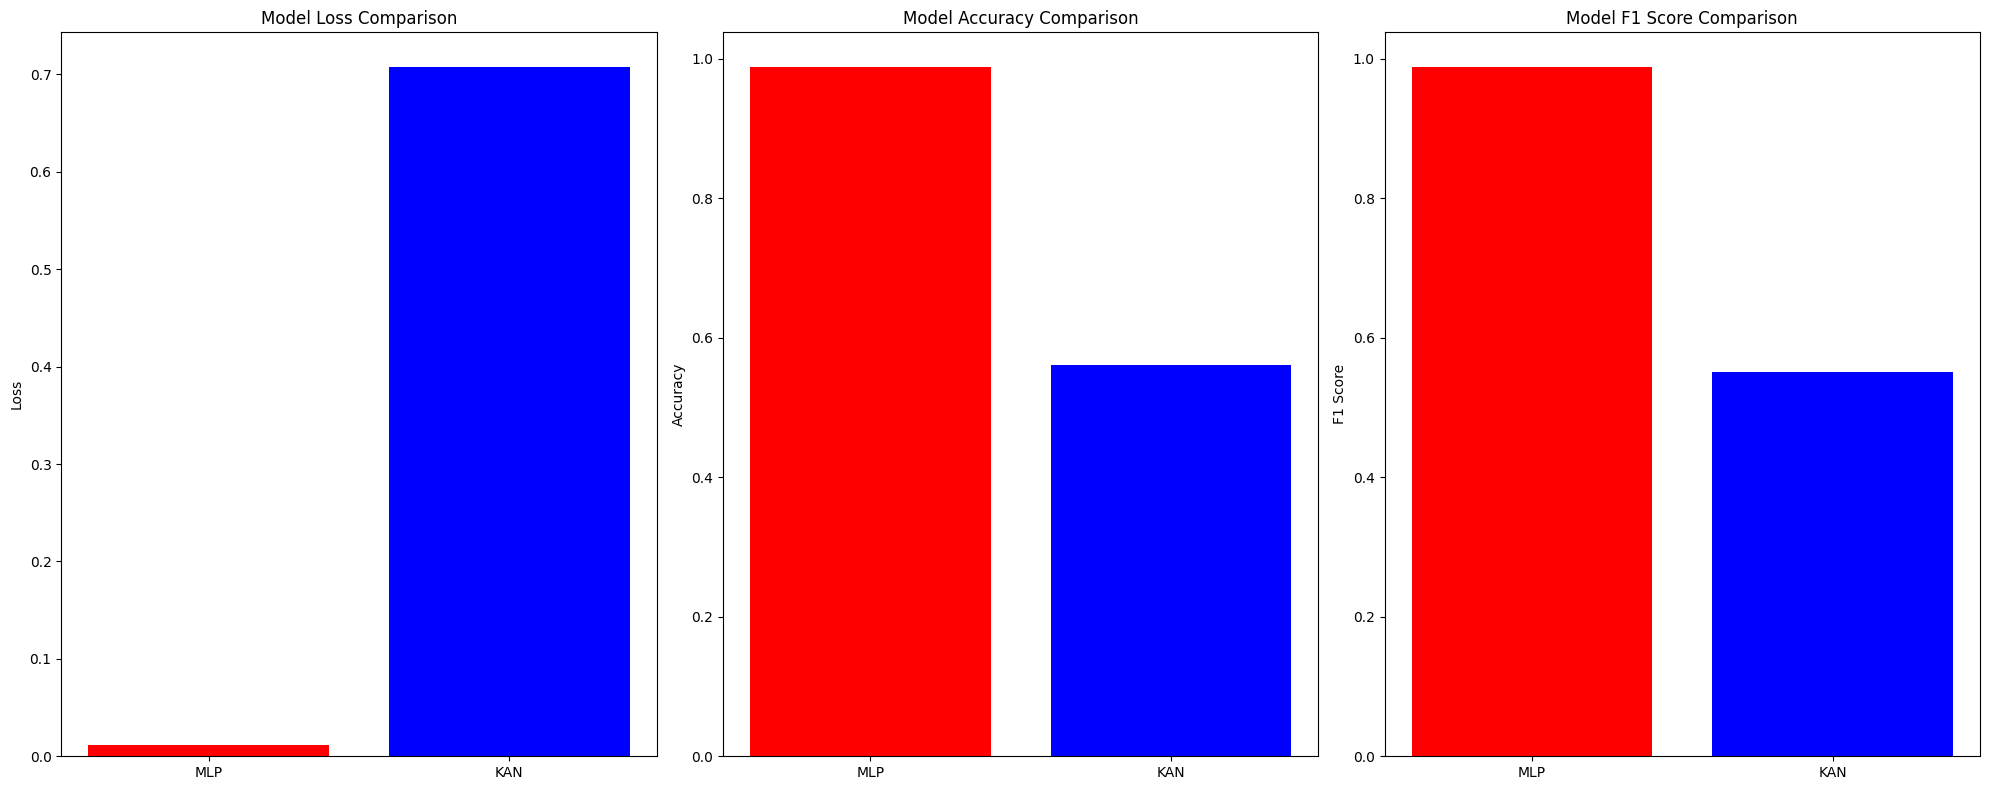

In [127]:
f1_mlp2 = f1_score(y_test, y_pred_mlp2, average='weighted')
f1_kan2 = f1_score(y_test, y_pred_kan2, average='weighted')
accuracy_mlp2 = accuracy_score(y_test, y_pred_mlp2)
accuracy_kan2 = accuracy_score(y_test, y_pred_kan2)
loss_mlp2 = loss_mlp2
loss_kan2 = loss_kan2

models2 = ['MLP', 'KAN']
losses2 = [loss_mlp2, loss_kan2]
accuracies2 = [accuracy_mlp2, accuracy_kan2]
f1_scores2 = [f1_mlp2, f1_kan2]

plot_results(models2,losses2, accuracies2,f1_scores2)
plt.show()